# BM, N = 20


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm, trange
from math import exp, sqrt, log
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import i0, i1, iv
from numpy import random
from torch.nn.functional import normalize
import matplotlib.pyplot as plt
%matplotlib inline

/home/pengxy2024/miniconda3/envs/QPDE/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# device = torch.device("cpu")

In [4]:
class PDEQnet(nn.Module):
  def __init__(self, dim, width, beta):
    super(PDEQnet, self).__init__()
    self.dim = dim
    self.width = width
    self.innerwidth = int(width/2)
    self.beta = beta

    self.wb = nn.Linear(self.dim, self.width).to(device)
    self.wb2 = nn.Linear(self.width, self.width).to(device)
    self.c = nn.Linear(self.width, 1, bias=False).to(device)

  def forward(self, x):
    x = self.wb(x)
    x = torch.sigmoid(x)
    #x = 1/(1+torch.pow(x,2))
    x = self.wb2(x)
    x = torch.sigmoid(x)
    #x = 1/(1+torch.pow(x,2))
    x = self.c(x)
    return x

  def assign_value(self):
    self.c.weight.data = torch.as_tensor(np.random.uniform(-1, 1, size=self.c.weight.shape), dtype=torch.float32).to(device)
    self.wb.weight.data = torch.as_tensor(np.random.normal(0, 1, size=self.wb.weight.shape),  dtype=torch.float32).to(device)
    self.wb.bias.data = torch.as_tensor(np.random.normal(0, 1, size=self.wb.bias.shape) ,dtype=torch.float32).to(device)
    self.wb2.weight.data = torch.as_tensor(np.random.normal(0, 1, size=self.wb2.weight.shape),  dtype=torch.float32).to(device)
    self.wb2.bias.data = torch.as_tensor(np.random.normal(0, 1, size=self.wb2.bias.shape) ,dtype=torch.float32).to(device)


In [5]:
# Parameters
dim = 20
gamma = 0.2

#d = [1 for i in range(dim)]

# Hyper parameters
N = 2**8
beta = 0.5+0.01
# Learning rate
initial_lr = 0.05 #* N**(2*beta-1)

# Auxiliary functions
def eta(grid):
  res = 1.0
  for i in range(dim):
    res = res -  grid[:,i]*grid[:,i]
  return res

def eta_diff(grid, count):
  return -2*grid[:,count]

def eta_diff_2(grid, count):
  return -2


# Monte Carlo
Nmc_max = 5000
Nmc_initial = 500
Nbasepoints = int(1e7)
# Default type


In [6]:
# Q fit, fixed grid
qnet = PDEQnet(dim, N, beta).to(device)
# initialization of PDEQnet paramters
qnet.assign_value()


In [7]:
#qnet.load_state_dict(torch.load('/content/6d, Q-learning, 30k epochs.pkl'))

In [8]:
# Create reservoir of points, so we don't have to sample every loop
#this is maybe the one thing that's worth doing on a GPU

source = torch.randn(size=(Nbasepoints, dim))
source = normalize(source, p=2.0) #Normalize to sphere
radius = torch.rand(size = (Nbasepoints,1))
radius = torch.pow(torch.rand(size = (Nbasepoints,1)),1/dim) #this gives unif over ball, but in high dimension may overemphasise the boundary of the ball through concentration.
source = radius*source #renormalize


  0%|          | 0/30000 [00:00<?, ?it/s]

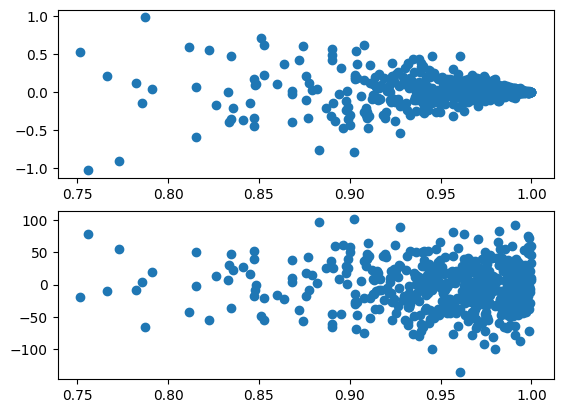

 16%|█▋        | 4947/30000 [27:09<2:17:33,  3.04it/s]


KeyboardInterrupt: 

In [9]:
#Training algorithm, main

# Num of epoch
Num_epo = 60000

# Loss level
loss_list = []

# Optmizer, scheduler
Qoptimizer = optim.RMSprop(qnet.parameters(), lr = initial_lr, alpha = 0.99, eps = 1e-08)
Qscheduler = LambdaLR(Qoptimizer, lr_lambda= lambda epoch: initial_lr/(1+(epoch//1000)))

fig, axs = plt.subplots(2,1)
# Training
for count1 in trange(Num_epo):

  Nmc = int(Nmc_initial+(Nmc_max-Nmc_initial)*(1+count1)/(1+Num_epo))

  epoch_sample = torch.randint(0,len(source), (Nmc,1))

  grid_list = []
  for i in range(dim):
    ent = [[u] for u in source[epoch_sample,i]] #grab sample from reservoir
    ent = torch.tensor(ent, requires_grad = True)
    grid_list.append(ent)
  grid_tuple = tuple(grid_list)
  grid = torch.cat(grid_tuple, 1)
  
  # Net output
  out = qnet(grid)
  out = out*eta(grid).reshape(out.shape)

  # Tensor reshape
  out_r =  torch.reshape(out, (-1,))
  # Compute partial derivatives and the Laplacian
  l2 = 0.0
  for count, entry in enumerate(grid_list):
    df_dx = torch.autograd.grad(out, entry, grad_outputs = torch.ones(entry.size()), create_graph = True)[0]
    d2f_dx2 = torch.autograd.grad(df_dx, entry, grad_outputs = torch.ones(entry.size()), create_graph = True)[0]
    df_dx = torch.reshape(df_dx, (-1,))
    d2f_dx2 = torch.reshape(d2f_dx2, (-1,))
    l2 += d2f_dx2#*eta(grid) + 2*df_dx*eta_diff(grid, count) + out_r* eta_diff_2(grid, count)
  
  #evaluate function
  l = out_r#*eta(grid)
  #evaluate PDE operator
  lq = 1 - gamma*l + 0.5*l2
  LQ = lq.clone().detach()

  # Q-learning
  loss_to_min =-1* torch.dot(LQ, l)
  #with torch.cuda.stream(s):
  Qoptimizer.zero_grad()
  loss_to_min.backward()
  Qoptimizer.step()
  Qscheduler.step()

  loss = float(torch.dot(LQ, LQ))
  loss/= Nmc
  loss_list.append(loss)
  
  if count1%10 == 0:
  #  print(loss)
    axs[1].clear()
    axs[0].clear()
    axs[0].scatter(np.sqrt(torch.sum(torch.pow(grid,2),dim=1).detach().cpu()),l.detach().cpu())
    axs[1].scatter(np.sqrt(torch.sum(torch.pow(grid,2),dim=1).detach().cpu()), LQ.detach().cpu())
    plt.pause(0.01)



In [ ]:
# Loss level
plt.figure(figsize=(7,4.5))
#ax = fig.add_subplot(1, 2, 1)
axis=[i for i in range(len(loss_list))]
axis = np.cumsum([1/(1+(i//500)) for i in range(len(loss_list))])
plt.xlabel('Cumulative training time')
plt.ylabel('Loss level')
plt.yscale('log') 
fig1 = plt.plot(axis,loss_list,'blue')

In [ ]:
# Loss level
plt.figure(figsize=(7,4.5))
#ax = fig.add_subplot(1, 2, 1)
axis=[i for i in range(len(loss_list))]
plt.xlabel('Training epoch')
plt.ylabel('Loss level')
plt.yscale('log') 
fig1 = plt.plot(axis,loss_list,'blue')

In [ ]:
log_loss_list = [log(x) for x in loss_list]
plt.figure(figsize=(7,4.5))
#ax = fig.add_subplot(1, 2, 1)
axis=[i for i in range(Num_epo)]
plt.xlabel('Number of epochs')
plt.ylabel('Loss level')
fig1 = plt.plot(axis[400:600], log_loss_list[400:600],'blue')

In [ ]:
# Plotting part 1: # Check if the approximator is symmetric
Nmc = 100
mesh = 100

test_axis = [i/mesh for i in range(1,mesh+1)]
relative_err_list = []
approx_list = []
sq_list = []
exact_list = []

radius = 1.0
for x in test_axis:
  exact = (1 - iv(9, sqrt(2*gamma)*x)/(x**9*iv(9, sqrt(2*gamma))))/gamma
  exact_list.append(exact)
  test_source = random.normal(0, 1, size=(Nmc//10, dim))
  test_source = torch.Tensor(test_source)
  test_source = normalize(test_source, p=2.0)
  test_source = x * test_source

  test_grid_list = []
  for i in range(dim):
    ent = [[u] for u in test_source[:,i]]
    ent = torch.tensor(ent, requires_grad = True).to(device)
    test_grid_list.append(ent)
  test_grid_tuple = tuple(test_grid_list)
  test_grid = torch.cat(test_grid_tuple, 1).to(device)

  test_out = qnet(test_grid).to(device)

# Tensor reshape
  test_out_r =  torch.reshape(test_out, (-1,)).to(device)
  test_l = test_out_r*eta(test_grid)

  sq_list.append(float(torch.dot(test_l-exact, test_l-exact)))
  relative_err_list.append(float(torch.max(abs(exact - test_l)/exact)))
  #relative_err_list.append(100*float(torch.mean(abs(exact - test_l))))
  approx_list.append(float(torch.mean(test_l)))

In [ ]:
# Plotting part 2
# Scatter plot #Test: the solution vs the approximator
scatter_axis = test_axis * (Nmc//10)
relative_err_list = []
approx_list = []
std_list = []


for x in tqdm(scatter_axis):
  test_source = random.normal(0, 1, size=(1, dim))
  test_source = torch.Tensor(test_source)
  test_source = normalize(test_source, p=2.0)
  test_source = x * test_source

  test_grid_list = []
  for i in range(dim):
    ent = [[u] for u in test_source[:,i]]
    ent = torch.tensor(ent, requires_grad = True).to(device)
    test_grid_list.append(ent)
  test_grid_tuple = tuple(test_grid_list)
  test_grid = torch.cat(test_grid_tuple, 1).to(device)

  test_out = qnet(test_grid).to(device)

# Tensor reshape
  test_out_r =  torch.reshape(test_out, (-1,)).to(device)
  test_l = test_out_r*eta(test_grid)
  approx_list.append(float(torch.mean(test_l)))


In [ ]:
# Exact vs Approximate
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('Distance from the Origin')
ax.set_ylabel('Value function')
ax.set_title('Solution of the PDE')
ax.scatter(scatter_axis, approx_list, s= .2, label = 'Approximated solution')
ax.plot(test_axis, exact_list,'red', label = 'Exact solution')
ax.legend()
axins = ax.inset_axes([0.05,0.05, 0.5, 0.5])
scatter_data_zoom = [approx_list[i] for i in range(len(scatter_axis)) if (0.48 < scatter_axis[i]  < 0.51)]
scatter_axis_zoom = [item for item in scatter_axis if (0.48 < item < 0.51)]
line_data_zoom = [exact_list[i] for i in range(len(test_axis)) if (0.48 < test_axis[i] < 0.51)]
line_axis_zoom = [item for item in test_axis if (0.48 < item < 0.51)]
axins.scatter(scatter_axis_zoom, scatter_data_zoom, s=.1)
axins.plot(line_axis_zoom, line_data_zoom, 'red')
axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins)

In [ ]:
# Mean square error
plt.xlabel('Distance from the Origin')
plt.ylabel('Mean square error')
plt.scatter(test_axis, sq_list,color = 'blue', s= .2)
plt.title('Mean square error of the approximator')

In [ ]:
# Max relative error
plt.xlabel('Distance from the Origin')
plt.ylabel('Percentage')
plt.scatter(test_axis, relative_err_list, s=0.2, color='gray',)
plt.gca().set_yticklabels([f'{x:.2%}' for x in plt.gca().get_yticks()]) 
plt.title('MaxRelative error in percentage')